In [106]:
import numpy as np
import pandas as pd
import seaborn as sns

#from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, f1_score
from sklearn.metrics import roc_curve, precision_recall_curve  
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import permutation_importance

## 3.5 Gradient Boosting<a id="Gradient Boosting"></a>
[Back to top](#top)

- Import preprocessed features as DataFrame and target variables as Series

In [107]:
# training and test sets with original data distribution

X_train = pd.read_csv('https://raw.githubusercontent.com/F4LLC0N3R/ML-Group-2---Diabetes/main/data/X_train.csv')
y_train = pd.read_csv('https://raw.githubusercontent.com/F4LLC0N3R/ML-Group-2---Diabetes/main/data/y_train.csv', squeeze=True)

X_test = pd.read_csv('https://raw.githubusercontent.com/F4LLC0N3R/ML-Group-2---Diabetes/main/data/X_test.csv')
y_test = pd.read_csv('https://raw.githubusercontent.com/F4LLC0N3R/ML-Group-2---Diabetes/main/data/y_test.csv', squeeze=True)

In [108]:
# resampled / balanced training sets

X_train_rus = pd.read_csv('https://raw.githubusercontent.com/F4LLC0N3R/ML-Group-2---Diabetes/main/data/X_train_rus.csv')
y_train_rus = pd.read_csv('https://raw.githubusercontent.com/F4LLC0N3R/ML-Group-2---Diabetes/main/data/y_train_rus.csv', squeeze=True)

X_train_ros = pd.read_csv('https://raw.githubusercontent.com/F4LLC0N3R/ML-Group-2---Diabetes/main/data/X_train_ros.csv')
y_train_ros = pd.read_csv('https://raw.githubusercontent.com/F4LLC0N3R/ML-Group-2---Diabetes/main/data/y_train_ros.csv', squeeze=True)

X_train_smote = pd.read_csv('https://raw.githubusercontent.com/F4LLC0N3R/ML-Group-2---Diabetes/main/data/X_train_smote.csv')
y_train_smote = pd.read_csv('https://raw.githubusercontent.com/F4LLC0N3R/ML-Group-2---Diabetes/main/data/y_train_smote.csv', squeeze=True)

### 3.5.1 Initial Model Building and Evaluation
[Back to top](#top)

#### Model Building
- Training a base model with default values to check our starting point.

In [163]:
clf = %time GradientBoostingClassifier(random_state=42).fit(X_train, y_train.values)

clf.score(X_test, y_test)

Wall time: 18.7 s


0.9125279642058165

- The base model almost has identical first results compared to the previous models. 

#### Model Evaluation

In [153]:
# Predict labels
y_pred = clf.predict(X_test)

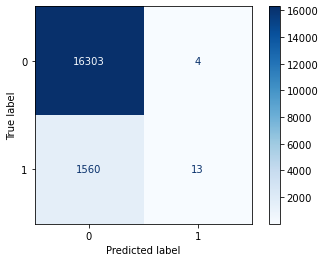

In [151]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

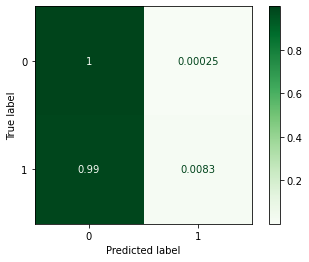

In [152]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Greens', normalize='true')

In [154]:
# Print evaluation metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     16307
           1       0.76      0.01      0.02      1573

    accuracy                           0.91     17880
   macro avg       0.84      0.50      0.49     17880
weighted avg       0.90      0.91      0.87     17880



Just like the other models, the accuracy score of the Gradient Boosted model is high, as more than 90% of the target values are the same (0). On the other hand, the Precision of the Gradient Boosted model is slightly better, with 75%. However, the F1-score and Recall score are once again lacking.

### 3.5.2 Hyperparameter Tuning
[Back to top](#top)

In [112]:
# Show hyperparameters and their values
clf.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [113]:
clf.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

Hyperparameters to be varied:  
- `criterion`: The default value is "friedman_mse", yet we also test "squared_error" to evaluate which one is better at measuring the quality of the split.
- `learning_rate` & `n_estimators`: "learning_rate" and "n_estimators" have a trade-off between each other. Both of these parameters are tuned to find the best synergy. 
- `max_depth`: To find the optimal limit to the number of nodes in the tree that is created.
- `min_weight_fraction_leaf`: 
- `max_features`: 
- `min_samples_split`: 

Just as before, we attempt to imptove the accuracy of the model to begin with. This is done by first conducting a Randomized Search to find the main hyperparameter ranges that we can work with. Once we know the approximate optimal range for the hyperparameters, we use GridSearchCV to further finetune some of the hyperparameters. 

In [114]:
param_grid = {'criterion': ['friedman_mse','squared_error'],
              'learning_rate': np.linspace(0.1, 1, 10),
              'max_depth': np.linspace(1, 300, 15, dtype='int'),
              'min_weight_fraction_leaf': [0.1,0.2,0.5,0.0],
              'max_features': ['auto','sqrt','log2'],
              'min_samples_split': [2, 10, 50],
              'n_estimators': [5, 10, 50, 100, 300],        
             }

In [115]:
random_search = RandomizedSearchCV(estimator=clf, 
                                   param_distributions = param_grid,
                                   n_jobs=-1,
                                   cv=3, #reduced to 3-fold to reduce runtime
                                   verbose=1)
%time random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Wall time: 49.5 s


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error'],
                                        'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'max_depth': array([  1,  22,  43,  65,  86, 107, 129, 150, 171, 193, 214, 235, 257,
       278, 300]),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_split': [2, 10, 50],
                                        'min_weight_fraction_leaf': [0.1, 0.2,
                                                                     0.5, 0.0],
                                        'n_estimators': [5, 10, 50, 100, 300]},
                   verbose=1)

In [116]:
rs_cv_results = pd.DataFrame(random_search.cv_results_)
rs_cv_results.sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_weight_fraction_leaf,param_min_samples_split,param_max_features,param_max_depth,param_learning_rate,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,0.486442,0.020142,0.079688,0.011325,10,0.1,10,sqrt,193,0.5,squared_error,"{'n_estimators': 10, 'min_weight_fraction_leaf...",0.911969,0.912020,0.912020,0.912003,0.000024,1
2,0.349412,0.043155,0.055679,0.005438,5,0.1,10,sqrt,107,0.6,friedman_mse,"{'n_estimators': 5, 'min_weight_fraction_leaf'...",0.911969,0.912020,0.912020,0.912003,0.000024,1
3,0.366414,0.034009,0.064016,0.004900,10,0.1,10,sqrt,86,0.3,friedman_mse,"{'n_estimators': 10, 'min_weight_fraction_leaf...",0.911969,0.912020,0.912020,0.912003,0.000024,1
4,5.363536,0.282607,0.261057,0.021281,300,0.1,10,sqrt,22,0.2,friedman_mse,"{'n_estimators': 300, 'min_weight_fraction_lea...",0.911969,0.912020,0.912020,0.912003,0.000024,1
6,2.742948,0.073121,0.164371,0.011441,300,0.1,10,log2,107,0.7,squared_error,"{'n_estimators': 300, 'min_weight_fraction_lea...",0.911969,0.912020,0.912020,0.912003,0.000024,1
7,0.223384,0.007589,0.045011,0.002162,10,0.2,10,sqrt,300,0.5,squared_error,"{'n_estimators': 10, 'min_weight_fraction_leaf...",0.911969,0.912020,0.912020,0.912003,0.000024,1
5,0.215379,0.017252,0.041342,0.001699,10,0,50,sqrt,1,0.7,squared_error,"{'n_estimators': 10, 'min_weight_fraction_leaf...",0.911745,0.912020,0.911796,0.911854,0.000119,7
0,35.791024,0.201265,0.263704,0.012685,50,0,10,log2,65,0.2,friedman_mse,"{'n_estimators': 50, 'min_weight_fraction_leaf...",0.911521,0.911460,0.911572,0.911518,0.000046,8
9,39.834946,0.535893,0.306400,0.009979,300,0,10,log2,43,0.5,friedman_mse,"{'n_estimators': 300, 'min_weight_fraction_lea...",0.911353,0.911293,0.911684,0.911443,0.000172,9
8,3.910873,0.052933,0.060680,0.003860,5,0,10,log2,235,0.4,squared_error,"{'n_estimators': 5, 'min_weight_fraction_leaf'...",0.888535,0.888249,0.889479,0.888754,0.000526,10


In [117]:
random_search.best_params_

{'n_estimators': 10,
 'min_weight_fraction_leaf': 0.1,
 'min_samples_split': 10,
 'max_features': 'sqrt',
 'max_depth': 193,
 'learning_rate': 0.5,
 'criterion': 'squared_error'}

In [122]:
clf_opt = random_search.best_estimator_

In [123]:
random_search.best_estimator_.score(X_test, y_test)

0.9120246085011185

- After getting an idea of the optimal hyperparameters, they are tuned slightly more with a GridSearchCV, which is more thorough.

In [118]:
gridsearch_param_grid = {'learning_rate': [0.4, 0.5, 0.6],
              'max_depth': [220, 230, 235],
              'min_weight_fraction_leaf': [0.2, 0.3, 0.4],
              'min_samples_split': [20, 35, 40],
              'n_estimators': [10, 13, 20],        
            }

In [119]:
# initialize grid search with roc-auc as score
gridsearch_roc = GridSearchCV(clf, param_grid = gridsearch_param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)

# fit on training data
%time gridsearch_roc.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Wall time: 2min 34s


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.4, 0.5, 0.6],
                         'max_depth': [220, 230, 235],
                         'min_samples_split': [20, 35, 40],
                         'min_weight_fraction_leaf': [0.2, 0.3, 0.4],
                         'n_estimators': [10, 13, 20]},
             scoring='roc_auc', verbose=1)

In [120]:
gridsearch_roc.best_params_

{'learning_rate': 0.4,
 'max_depth': 220,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.2,
 'n_estimators': 20}

In [121]:
gridsearch_roc.best_estimator_.score(X_test, y_test)

0.9120246085011185

#### 'Optimized' Model Evaluation

In [124]:
# Predict labels
y_pred = clf_opt.predict(X_test)

# Print metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     16307
           1       0.00      0.00      0.00      1573

    accuracy                           0.91     17880
   macro avg       0.46      0.50      0.48     17880
weighted avg       0.83      0.91      0.87     17880



C:\Users\dnils\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dnils\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dnils\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


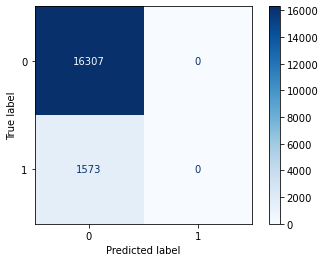

In [125]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')


### 3.5.4 Weighed Gradient Boosting to improve ROC-AUC
[Back to top](#top)

NOT APPLICABLE!!!!

In [126]:
# calculate prediction probabilities
y_prob = clf.predict_proba(X_test)

# calculate roc-auc
roc_auc_score(y_test, y_prob[:,1])

0.6576479291515221

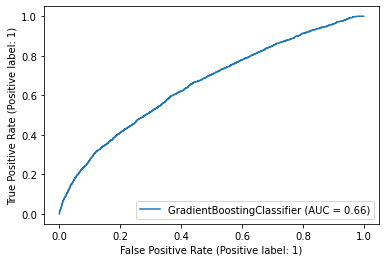

In [127]:
# plot roc curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)

In [128]:
print(f'Class weights in "balanced" mode: {y_train.shape[0] / (y_train.nunique() * np.bincount(y_train))}')


Class weights in "balanced" mode: [0.548244   5.68199153]


In [129]:
# define model

# https://stackoverflow.com/questions/35539937/is-there-class-weight-or-alternative-way-for-gradientboostingclassifier-in-skl
# "Gradient Boosting Machines (GBM) deals with class imbalance by constructing successive training sets based on incorrectly classified examples"
# no class weight for XGBoost
clf_balanced = make_pipeline(MinMaxScaler(), GradientBoostingClassifier(random_state=42, class_weight='balanced'))

TypeError: __init__() got an unexpected keyword argument 'class_weight'

#### Probability Calibration

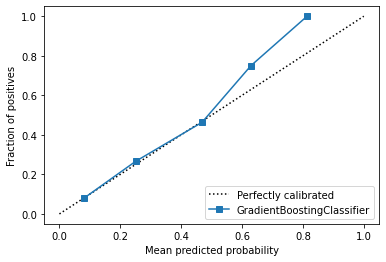

In [130]:
CalibrationDisplay.from_estimator(clf, X_test, y_test)

In [131]:
# fit and calibrate model on training data

clf_calibrated = CalibratedClassifierCV(clf, n_jobs=-1)
%time clf_calibrated.fit(X_train, y_train)

Wall time: 18.7 s


CalibratedClassifierCV(base_estimator=GradientBoostingClassifier(random_state=42),
                       n_jobs=-1)

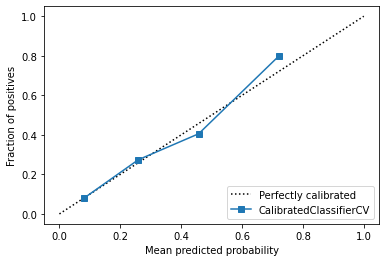

In [132]:
CalibrationDisplay.from_estimator(clf_calibrated, X_test, y_test)

#### G-Mean Optimizing Threshold Selection

In [133]:
# predict probabilities
y_prob = clf.predict_proba(X_test)

# probabilities for the positive outcome only
y_prob_1 = y_prob[:, 1]

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_1)

# calculate g-mean for every threshold
gmeans = np.sqrt(tpr * (1-fpr))

In [134]:
# Save in dataframe and sort by gmean

df_thresh = pd.DataFrame({'Threshold': thresholds, 'FPR': fpr, 'TPR': tpr, 'GMean': gmeans})
df_thresh.sort_values(by='GMean', ascending=False)

,Threshold,FPR,TPR,GMean
1842,0.082945,0.365610,0.596313,0.615057
1840,0.082992,0.365365,0.595677,0.614848
1856,0.082718,0.368860,0.598856,0.614786
1844,0.082846,0.366898,0.596949,0.614760
1850,0.082760,0.368247,0.598220,0.614758
...,...,...,...,...
2,0.637044,0.000000,0.001907,0.043671
3,0.619841,0.000061,0.001907,0.043670
1,0.813607,0.000000,0.000636,0.025214
0,1.813607,0.000000,0.000000,0.000000


In [135]:
# get the best threshold
best_thresh = thresholds[np.argmax(gmeans)]
best_thresh

0.08294515925251045

#### Weighed Model Evaluation

In [136]:
# calculate probability estimates for class 1
y_prob = clf.predict_proba(X_test)
y_prob_1 = y_prob[:,1]

#calculate predictions using custom discrimination threshold
y_pred = (y_prob_1 >= best_thresh).astype(int)

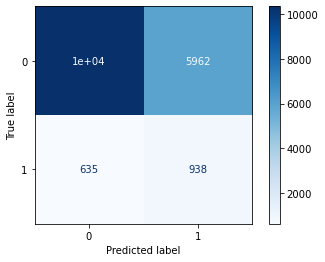

In [137]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

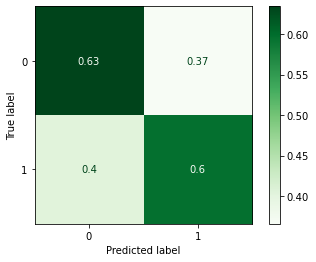

In [138]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', cmap='Greens')

In [139]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.63      0.76     16307
           1       0.14      0.60      0.22      1573

    accuracy                           0.63     17880
   macro avg       0.54      0.62      0.49     17880
weighted avg       0.87      0.63      0.71     17880



### 3.5.6 Gradient Boosting on Resampled Data
[Back to top](#top)

In [140]:
clf.fit(X_train_ros, y_train_ros)

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.66      0.77     16307
           1       0.14      0.56      0.22      1573

    accuracy                           0.65     17880
   macro avg       0.54      0.61      0.50     17880
weighted avg       0.87      0.65      0.73     17880



clf.fit(X_train_rus, y_train_rus)

print(classification_report(y_test, clf.predict(X_test)))

### 3.5.7 Permutation Importance
[Back to top](#top)

In [160]:
# Finding the most important features for the model.
result = permutation_importance(clf, X_test, y_test, n_repeats=10,random_state=0)

In [161]:
df_best_feature = pd.DataFrame({'features':X_test.columns,'mean_importance':result.importances_mean})

In [162]:
df_best_feature.sort_values(ascending=False, by='mean_importance')

,features,mean_importance
7,number_inpatient,0.000610
28,discharge_disposition_id_Discharged/transferre...,0.000280
1,time_in_hospital,0.000240
45,admission_source_id_ Emergency Room,0.000224
34,discharge_disposition_id_Discharged/transferre...,0.000196
...,...,...
220,insulin_No,-0.000011
20,admission_type_id_Urgent,-0.000022
152,diag_2_diseases of the nervous system and sens...,-0.000050
169,diag_3_diseases of the respiratory system,-0.000056


discharge_disposition_id_Discharged to home 0.0521  +/- 0.001668
discharge_disposition_id_Discharged/transferred to SNF 0.0183  +/- 0.000834
discharge_disposition_id_Discharged/transferred to home with home health service 0.0121  +/- 0.000413
number_inpatient 0.0104  +/- 0.001320
discharge_disposition_id_Expired 0.0084  +/- 0.000455
discharge_disposition_id_Discharged/transferred to another rehab fac including rehab units of a hospital . 0.0079  +/- 0.000515
discharge_disposition_id_Discharged/transferred to another short term hospital 0.0036  +/- 0.000511
discharge_disposition_id_Hospice / home 0.0027  +/- 0.000270
discharge_disposition_id_Not Mapped 0.0022  +/- 0.000200
discharge_disposition_id_Discharged/transferred to a long term care hospital. 0.0021  +/- 0.000207
discharge_disposition_id_Discharged/transferred to another type of inpatient care institution 0.0020  +/- 0.000438
medical_specialty_Orthopedics-Reconstructive 0.0016  +/- 0.000350
metformin_No 0.0014  +/- 0.000420
disch

### 3.5.8 Conclusion
[Back to top](#top)

- The GradientBoosting model did not outperform the other models